## Contextual bandit (LinUCB)
---

From the paper : 

Li, L., Chu, W., Langford, J., & Schapire, R. E. (2010, April). A contextual-bandit approach to personalized news article recommendation. In Proceedings of the 19th international conference on World wide web (pp. 661-670). ACM. [Link to paper](http://rob.schapire.net/papers/www10.pdf)

written by _Etienne KINTZLER_

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
np.random.seed(123)

#### Defining constants

In [3]:
N_TRIAL = 2000
N_ARMS = 16
N_FEATURE = 5
BEST_ARMS = [3, 7, 9, 15]

### 1. Problem setting

#### Setting problems parameters

In [4]:
def make_design_matrix(n_trial, n_arms, n_feature):
    available_arms = np.arange(n_arms)
    X = np.array([[np.random.uniform(low=0, high = 1, size=n_feature) for _ in available_arms] for _ in np.arange(n_trial)])
    return X

def make_theta(n_arms, n_feature, best_arms, bias = 1) :
    true_theta = np.array([np.random.normal(size = n_feature, scale = 1/4) for _ in np.arange(n_arms)])
    true_theta[best_arms] = true_theta[best_arms] + bias
    return true_theta

def generate_reward(arm, x, theta, scale_noise = 1/10):
    signal = theta[arm].dot(x)
    noise  = np.random.normal(scale = scale_noise) 
    return (signal + noise)

def make_regret(payoff, oracle):
    return np.cumsum(oracle - payoff)

For each arm, feature vector is _i.i.d_ and simulated according to $U\left([0, 1]\right)$.

Theta vector is simulated according to $N\left(\mathbf{0}_d, c\mathbf{I}_d\right)$ with c = 1/4.

Highly profitable arms are created adding positive bias to $\theta$. These arms are defined by the constant BEST_ARMS.

By hypothesis, the _expected bayoff_ is linear in its feature vector $\boldsymbol{x}_{t,a}$ with some unknown coefficient vector $\theta_a^*$ :

$\mathbb{E}[r_{t, a}|\boldsymbol{x}_{t,a}] = \boldsymbol{x}^T_{t,a}\theta_a^*$.

Regret is defined as $R_A(T) := \mathbb{E}\left[\sum_{t=1}^T r_{t, a_t^*}\right] - \mathbb{E}\left[\sum_{t=1}^T r_{t, a_t}\right]$.

#### Simulation of design matrix and weight vector (theta)

In [5]:
X = make_design_matrix(n_trial = N_TRIAL, n_arms = N_ARMS, n_feature = N_FEATURE)
true_theta = make_theta(n_arms = N_ARMS, n_feature = N_FEATURE, best_arms = BEST_ARMS)

#### Graphical representation of average payoff per arm

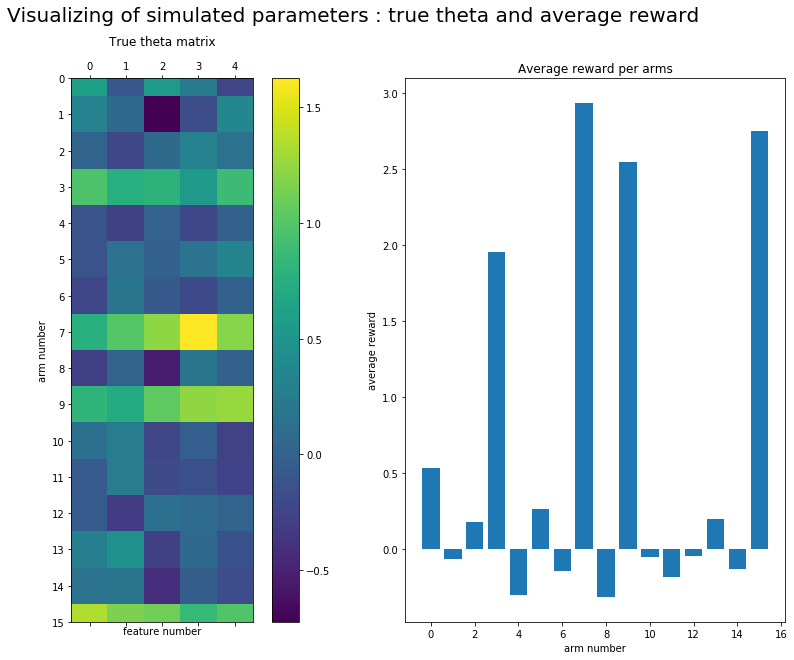

In [124]:
f, (left, right) = plt.subplots(1, 2, figsize=(15, 10))

f.suptitle(t="Visualizing of simulated parameters : true theta and average reward", fontsize=20)

left.matshow(true_theta)
f.colorbar(left.imshow(true_theta), ax=left)
left.set_xlabel("feature number")
left.set_ylabel("arm number")
left.set_yticks(np.arange(N_ARMS))
left.set_title("True theta matrix")

ave_reward = np.mean([[generate_reward(arm=arm, x=X[t, arm], theta=true_theta) \
                       for arm in np.arange(N_ARMS)] \
                      for t in np.arange(N_TRIAL)], axis = 0)
right.bar(np.arange(N_ARMS), ave_reward)
right.set_title("Average reward per arms")
right.set_xlabel("arm number")
right.set_ylabel("average reward")
plt.show()

On average, the reward is much higher for the best arms. In this example, the arm 7 is the most profitable.

### 2. Algorithm (disjoint version)
#### Algorithm definition

In [16]:
def linUCB_disjoint(alpha, X, generate_reward, true_theta):
    print("linUCB disjoint with exploration parameter alpha: ", alpha)
    n_trial, n_arms, n_feature = X.shape
    
    # 1.Initialise object
    # 1.1.output object
    arm_choice, r_payoff = [np.empty(n_trial) for _ in range(2)]
    theta  = np.empty(shape=(n_trial, n_arms, n_feature)) #n_trial pour assurer la traçabilité. Il y a bien un vecteur théta par bras
    p      = np.empty(shape=(n_trial, n_arms)) #n_trial pour la traçabilité
    
    # 1.2.intermediate object
    A = np.array([np.diag(np.ones(shape=n_feature)) for _ in np.arange(n_arms)])
    b = np.array([np.zeros(shape=n_feature) for _ in np.arange(n_arms)])

    # 2. Algo
    for t in np.arange(n_trial):
        
        #Compute estimates (theta) and prediction (p) for all arms
        for a in np.arange(n_arms) :
            inv_A       = np.linalg.inv(A[a]) # caching matrix inversion result because used twice
            theta[t, a] = inv_A.dot(b[a])
            p[t, a]     = theta[t, a].dot(X[t, a]) + alpha * np.sqrt(X[t, a].dot(inv_A).dot(X[t, a]))
        
        #chosing best arms
        chosen_arm    = np.argmax(p[t])
        x_chosen_arm  = X[t, chosen_arm]
        r_payoff[t]   = generate_reward(arm=chosen_arm, x=x_chosen_arm, theta=true_theta)
        arm_choice[t] = chosen_arm
        
        #update intermediate objects (A and b)
        A[chosen_arm] += np.outer(x_chosen_arm, x_chosen_arm.T)
        b[chosen_arm] += r_payoff[t] * x_chosen_arm
    
    return dict(theta=theta, p=p, arm_choice = arm_choice, r_payoff=r_payoff)

#### Defining oracle and random payoff

In [17]:
oracle = np.array([np.max([generate_reward(arm=arm, x=X[t, arm], theta=true_theta) for arm in np.arange(N_ARMS)]) \
         for t in np.arange(N_TRIAL)])
payoff_random = np.array([generate_reward(arm=np.random.choice(N_ARMS), x=X[t, np.random.choice(N_ARMS)], theta=true_theta)\
                          for t in np.arange(X.shape[0])])
regret_random = make_regret(payoff=payoff_random, oracle = oracle)

#### Algorithm testing for various alpha

In [18]:
alpha_to_test = [0, 1, 2.5, 5, 10, 20]
results_dict = {alpha: linUCB_disjoint(alpha = alpha, X=X, generate_reward=generate_reward, true_theta=true_theta)\
                for alpha in alpha_to_test}

linUCB disjoint with exploration parameter alpha:  0
linUCB disjoint with exploration parameter alpha:  1
linUCB disjoint with exploration parameter alpha:  2.5
linUCB disjoint with exploration parameter alpha:  5
linUCB disjoint with exploration parameter alpha:  10
linUCB disjoint with exploration parameter alpha:  20


### 3. Analyzing regrets, coefficients estimates and chosen arms



#### Function definition

In [25]:
def plot_regrets(results, oracle):
    [plt.plot(make_regret(payoff=x["r_payoff"], oracle = oracle), label = "alpha: " + str(alpha)) \
     for (alpha, x) in results.items()]
    
def plot_estimates(x, alpha, true_theta=None, abs_ylim = None, ncol = 4):
    print("Esimates plot for alpha: ", alpha)
    if true_theta is not None:
            print("Parameter true_theta has been supplied. Plotting convergence")
    for i, arm in enumerate(np.arange(N_ARMS)):
        plt.subplot(np.ceil(N_ARMS/ncol), ncol, 1 + i)
        if true_theta is not None:
            data_to_plot = pd.DataFrame(x[alpha]["theta"][:, arm, :]) - true_theta[arm]
        else : 
            data_to_plot = pd.DataFrame(x[alpha]["theta"][:, arm, :]) 
        plt.plot(data_to_plot)
        plt.hlines(y=0, xmin = 0, xmax = N_TRIAL, linestyles=":")
        
        if (arm in BEST_ARMS) :
            title = "Arm: " + str(arm) + " (best)"
        else :
            title = "Arm: " + str(arm) 
        plt.title(title)
        if abs_ylim is not None :
            plt.ylim([-abs_ylim, abs_ylim])
    plt.legend(["c" + str(feature) for feature in np.arange(N_FEATURE)])   
    
def plot_selected_arms(x, bar_width = .15):
    for (i, alpha) in enumerate(x):
        xi, yi = np.unique(x[alpha]["arm_choice"], return_counts=True)
        plt.bar(xi + i * bar_width, yi, label="alpha: " + str(alpha), width=bar_width)

    plt.xticks(np.arange(N_ARMS) + round(len(x)/2) * bar_width, np.arange(N_ARMS))
    plt.legend()    

#### 3.1. Representing regret according to various level of exploration value

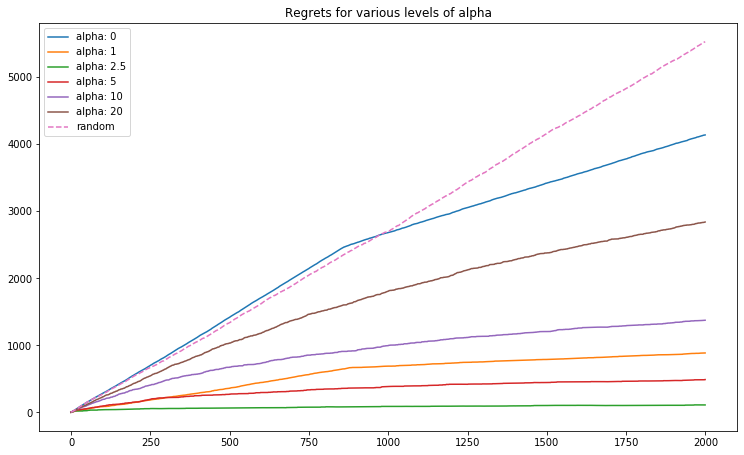

In [125]:
plt.figure(figsize = (12.5, 7.5))
plot_regrets(results_dict, oracle)
plt.plot(make_regret(payoff=payoff_random, oracle=oracle), label="random", linestyle='--')
plt.legend()
plt.title("Regrets for various levels of alpha")
plt.show()

#### 3.2. Coefficients path according to the time

Esimates plot for alpha:  2.5


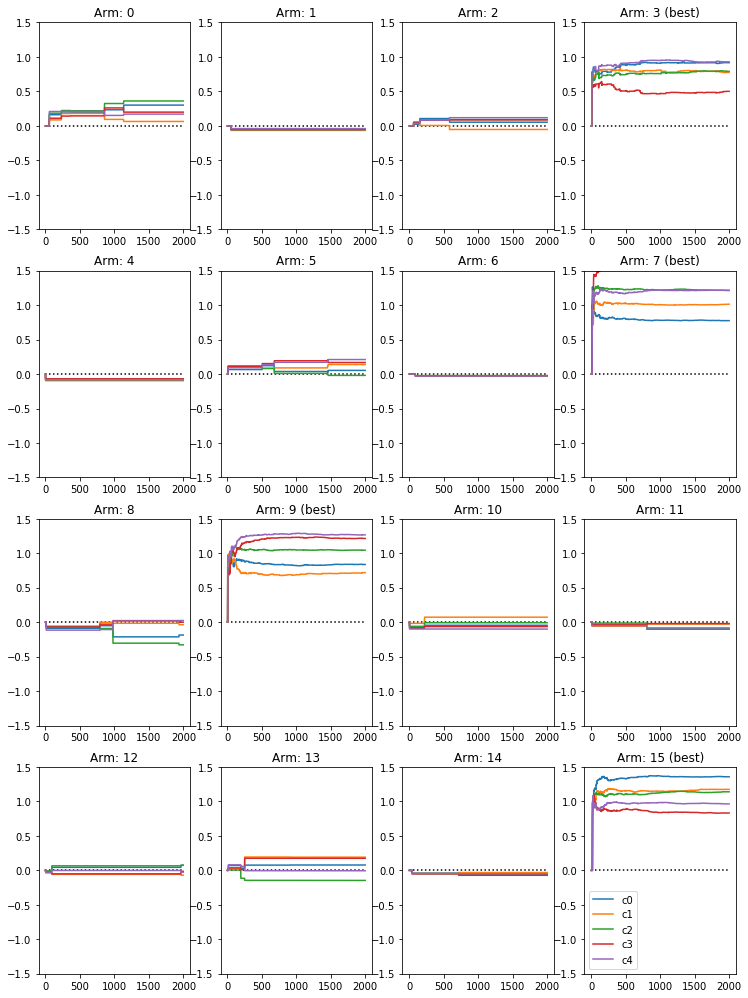

In [34]:
plt.figure(figsize = (12.5, 17.5))
plot_estimates(results_dict, alpha = 2.5, ncol = 4, abs_ylim=3/2)

#### Convergence of estimates
The more the arm is visited, the faster the convergence of estimate. Hence convergence will be faster :
- for the arm with higher payoff (BEST_ARMS)
- for experimentation with higher exploration term alpha

The following graphs show the convergence for different values of alpha (2.5 and 20).

Esimates plot for alpha:  2.5
Parameter true_theta has been supplied. Plotting convergence


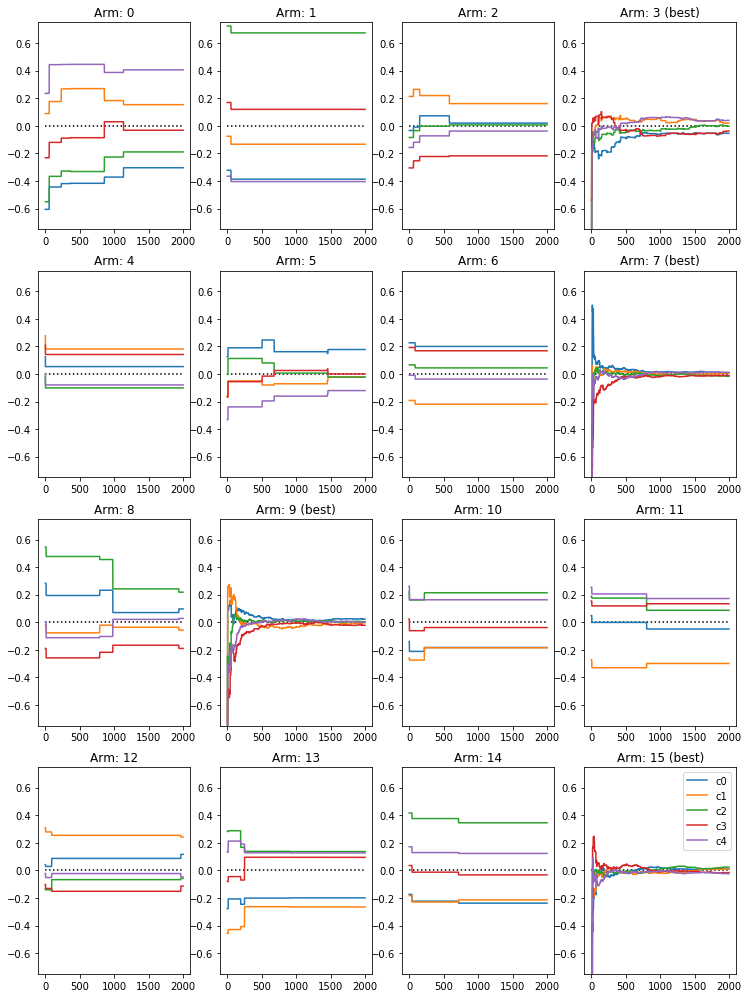

In [35]:
plt.figure(figsize = (12.5, 17.5))
plot_estimates(results_dict, alpha = 2.5, true_theta=true_theta, abs_ylim=3/4)

Esimates plot for alpha:  20
Parameter true_theta has been supplied. Plotting convergence


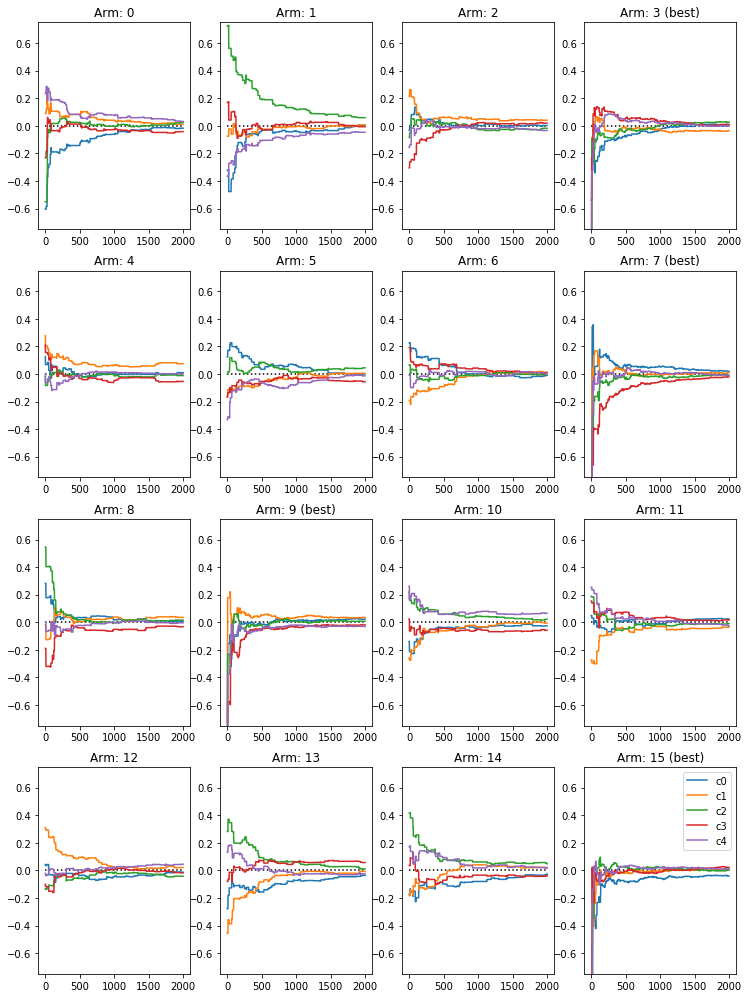

In [36]:
plt.figure(figsize = (12.5, 17.5))
plot_estimates(results_dict, alpha = 20, true_theta=true_theta, abs_ylim=3/4)

#### 3.3. Number of time each arm has been selected

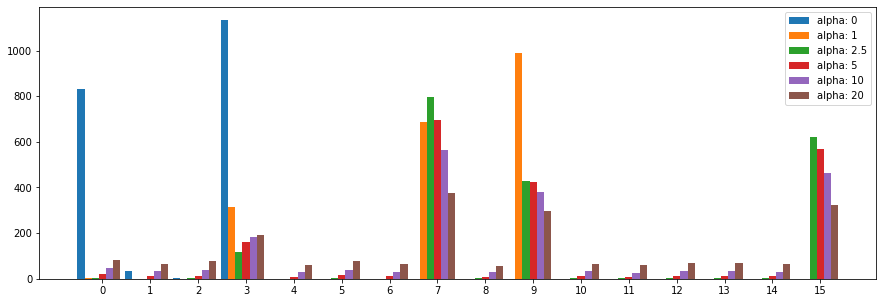

In [37]:
plt.figure(figsize = (15, 5))
plot_selected_arms(results_dict)

Low exploration parameter (alpha = 1) prevents the algorithm from visiting highly rentable arm (the arm 15 for instance).
No exploration causes the algorithm to get stuck in the first highly rentable arm found.